In [72]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

x , y = make_circles(n_samples , 
                     noise = 0.03,
                     random_state = 420)

In [73]:
len(x) , len(y)

(1000, 1000)

In [74]:
x[:5] , y[:5]

(array([[-0.73582175,  0.37745757],
        [-0.25385596, -0.94868013],
        [ 0.82522139,  0.09447006],
        [-0.69191553,  0.33789909],
        [ 0.60208011,  0.5111804 ]]),
 array([1, 0, 1, 1, 1]))

In [75]:
import pandas as pd
circles = pd.DataFrame({"x1":x[:,0],
                        "x2":x[:,1],
                       "labels":y})

In [76]:
circles.head()

,x1,x2,labels
0,-0.735822,0.377458,1
1,-0.253856,-0.948680,0
2,0.825221,0.094470,1
3,-0.691916,0.337899,1
4,0.602080,0.511180,1


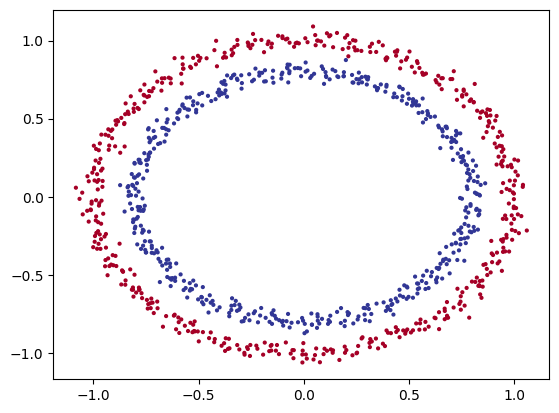

In [77]:
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c = y,
            s=4,
            cmap=plt.cm.RdYlBu)

In [78]:
import torch
x.dtype

dtype('float64')

In [79]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [80]:
y.dtype

torch.float32

In [81]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=420)

In [82]:
len(x_train) , len(x_test) 

(800, 200)

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [84]:
from torch import nn

class circleModel(nn.Module):
    def __init__(self):
        super().__init__()
        #create 2 nn.Linear() layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features = 2 , out_features = 5) # any number of out_features preferably multiple of 8
        self.layer_2 = nn.Linear(in_features = 5 , out_features = 1) # in_features = out_features of previous layer

    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2

model_0 = circleModel().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [85]:
model_0 = nn.Sequential(
    nn.Linear(in_features = 2 , out_features = 5),
    nn.Linear(in_features = 5 , out_features = 1 )
).to(device)

model_0 # using nn.Sequential

#next(model_1.parameters()).device

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [86]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [87]:
with torch.inference_mode():
    untrained_preds = model_0(x_test.to(device))
print(f"len preds: {len(untrained_preds)} shape preds: {untrained_preds.shape}")
print(f"len x : {len(x_test)} shape x : {x_test.shape}")
print(f"first 10 preds : \n {untrained_preds[:10]}")
print(f"first 10 labels : \n {y_test[:10]}")

len preds: 200 shape preds: torch.Size([200, 1])
len x : 200 shape x : torch.Size([200, 2])
first 10 preds : 
 tensor([[-0.0297],
        [ 0.0269],
        [-0.1246],
        [-0.0071],
        [-0.0733],
        [-0.1640],
        [-0.1287],
        [-0.0117],
        [-0.1618],
        [-0.0024]], device='cuda:0')
first 10 labels : 
 tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 1.])


In [88]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)


In [89]:
def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [90]:
#logits
with torch.inference_mode():
    y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[-0.0297],
        [ 0.0269],
        [-0.1246],
        [-0.0071],
        [-0.0733]], device='cuda:0')

In [91]:
# sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)

y_pred_probs

torch.round(y_pred_probs)


tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [92]:
# logits -> prediction probs -> prediction labels 

y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device)))[:5])

print(torch.eq(y_preds.squeeze() , y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 0., 0.], device='cuda:0')

In [93]:
torch.manual_seed(42)
torch.manual_seed(42)

epochs = 1000

x_train , y_train = x_train.to(device) , y_train.to(device) 
x_test , y_test = x_test.to(device) , y_test.to(device)


for ep in range (epochs):
    model_0.train()

    y_logits = model_0(x_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #testing

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
    if ep % 100 == 0:
        print(f"Epoch : {ep} | Loss : {loss:.5f} | Accuracy : {acc:.5f} | Test loss : {test_loss:.5f} Test Acc : {test_acc:.5f}")

Epoch : 0 | Loss : 0.69448 | Accuracy : 46.00000 | Test loss : 0.69330 Test Acc : 46.50000
Epoch : 100 | Loss : 0.69300 | Accuracy : 54.00000 | Test loss : 0.69481 Test Acc : 52.50000
Epoch : 200 | Loss : 0.69298 | Accuracy : 57.75000 | Test loss : 0.69472 Test Acc : 52.50000
Epoch : 300 | Loss : 0.69297 | Accuracy : 55.00000 | Test loss : 0.69474 Test Acc : 50.50000
Epoch : 400 | Loss : 0.69297 | Accuracy : 56.12500 | Test loss : 0.69477 Test Acc : 51.00000
Epoch : 500 | Loss : 0.69297 | Accuracy : 57.37500 | Test loss : 0.69479 Test Acc : 53.50000
Epoch : 600 | Loss : 0.69297 | Accuracy : 58.00000 | Test loss : 0.69480 Test Acc : 54.50000
Epoch : 700 | Loss : 0.69297 | Accuracy : 58.25000 | Test loss : 0.69481 Test Acc : 54.50000
Epoch : 800 | Loss : 0.69297 | Accuracy : 58.62500 | Test loss : 0.69482 Test Acc : 54.50000
Epoch : 900 | Loss : 0.69297 | Accuracy : 58.75000 | Test loss : 0.69483 Test Acc : 54.50000


In [94]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("already exists")
else: 
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py",'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions , plot_decision_boundary

already exists


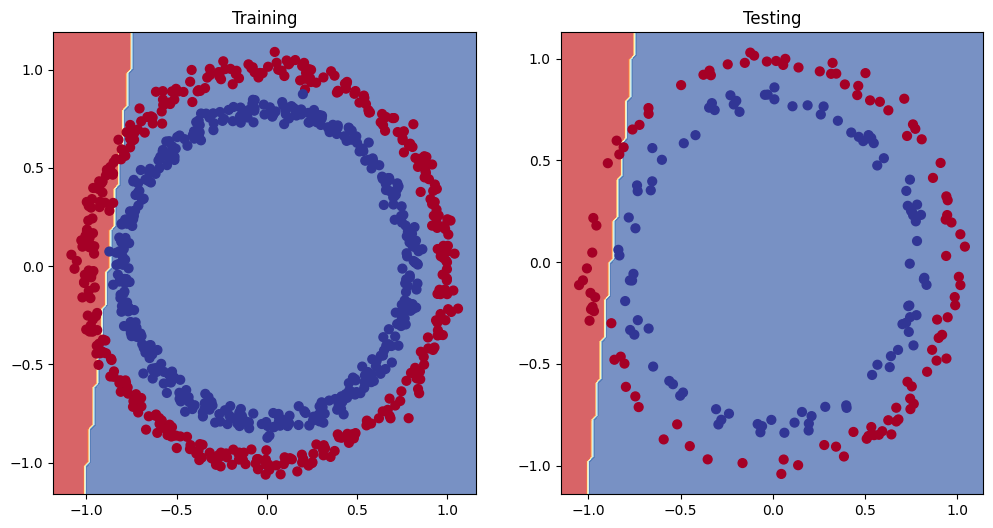

In [95]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(model_0,x_train,y_train) 


plt.subplot(1,2,2 )
plt.title("Testing")
plot_decision_boundary(model_0,x_test,y_test) 

In [96]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2 , out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10 , out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10 , out_features = 1)

        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [97]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.1)


In [98]:
torch.manual_seed(42)

x_train , y_train  = x_train.to(device) , y_train.to(device)
x_test , y_test = x_test.to(device) , y_test.to(device)

epochs = 1000

for ep in range(epochs):

    model_2.train()

    y_logits = model_2(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if ep % 100 == 0:
        print(f"Epoch: {ep} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.75% | Test Loss: 0.69302, Test Accuracy: 47.00%
Epoch: 100 | Loss: 0.69127, Accuracy: 51.50% | Test Loss: 0.69111, Test Accuracy: 47.50%
Epoch: 200 | Loss: 0.68994, Accuracy: 73.00% | Test Loss: 0.68922, Test Accuracy: 75.50%
Epoch: 300 | Loss: 0.68820, Accuracy: 63.38% | Test Loss: 0.68681, Test Accuracy: 63.00%
Epoch: 400 | Loss: 0.68580, Accuracy: 57.88% | Test Loss: 0.68352, Test Accuracy: 59.50%
Epoch: 500 | Loss: 0.68250, Accuracy: 56.88% | Test Loss: 0.67897, Test Accuracy: 58.50%
Epoch: 600 | Loss: 0.67745, Accuracy: 56.00% | Test Loss: 0.67205, Test Accuracy: 58.50%
Epoch: 700 | Loss: 0.66971, Accuracy: 56.75% | Test Loss: 0.66222, Test Accuracy: 58.00%
Epoch: 800 | Loss: 0.65746, Accuracy: 64.12% | Test Loss: 0.64788, Test Accuracy: 65.00%
Epoch: 900 | Loss: 0.63368, Accuracy: 75.12% | Test Loss: 0.62433, Test Accuracy: 78.00%


In [99]:
model_2.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(x_test))).squeeze()

y_preds[:10] , y_test[:10]

(tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 1.], device='cuda:0'))

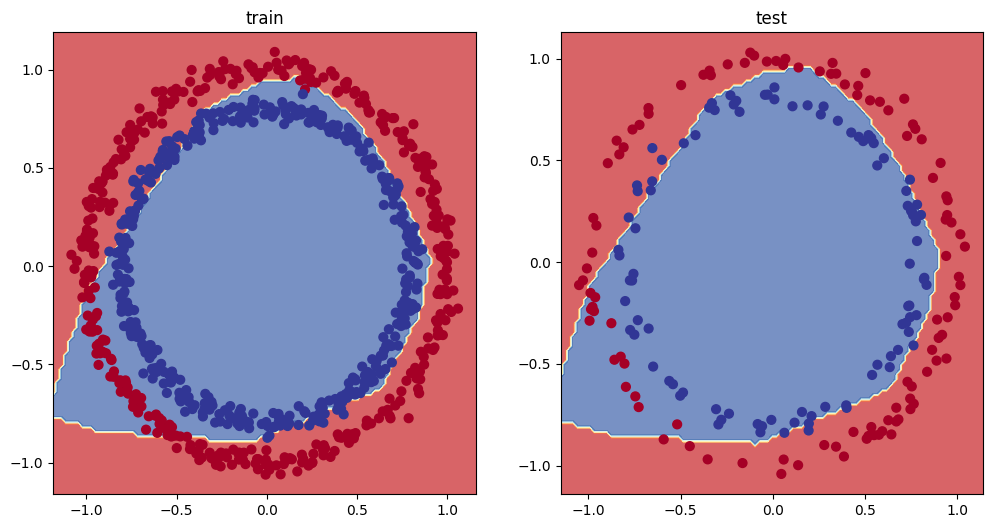

In [100]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_2,x_train,y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_2,x_test,y_test)

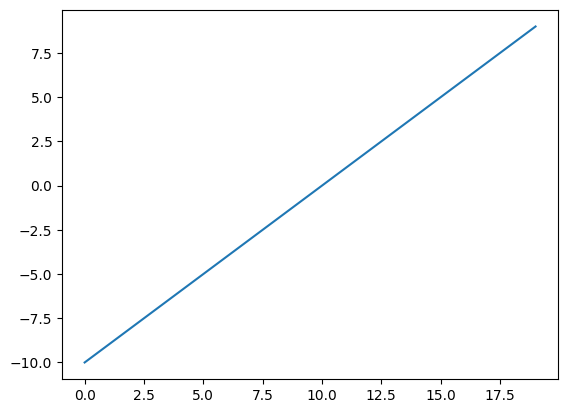

In [101]:
a = torch.arange(-10,10,1,dtype = torch.float32)
a
plt.plot(a)

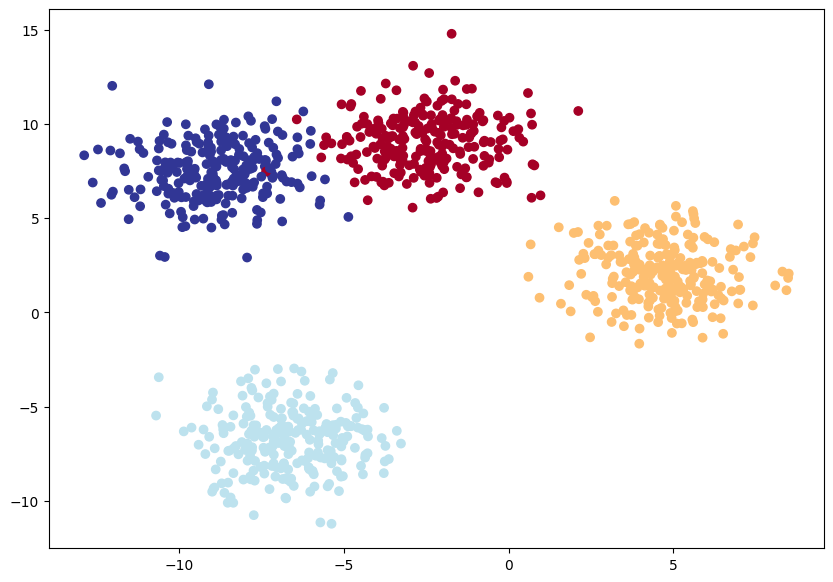

In [166]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4 
NUM_FEATURES = 2
RAND_STATE = 42

x_blob , y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RAND_STATE)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)


x_b_train , x_b_test , y_b_train , y_b_test = train_test_split(x_blob,
                                                               y_blob,
                                                               test_size = 0.2,
                                                               random_state = RAND_STATE)

plt.figure(figsize = (10,7))
plt.scatter(x_blob[:,0] , x_blob[:,1] , c = y_blob , cmap = plt.cm.RdYlBu) 

In [167]:
class blobModel(nn.Module):

    def __init__(self,input_features , output_features , hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(nn.Linear(in_features = input_features , out_features = hidden_units),
                                                nn.Linear(in_features = hidden_units , out_features = hidden_units),
                                                nn.Linear(in_features = hidden_units , out_features = output_features))
    
    def forward(self,x):
        return self.linear_layer_stack(x)

model_4 = blobModel(input_features = 2,
                    output_features = 4,
                    hidden_units = 8).to(device)

model_4

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [168]:
torch.unique(y_b_train)

tensor([0, 1, 2, 3])

In [169]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_4.parameters() , lr = 0.1)

In [170]:
x_b_test.dtype

torch.float32

In [171]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_b_test.to(device))

y_logits[:10]

tensor([[-1.3560,  0.1868, -1.1416, -0.5434],
        [ 1.8856, -4.4030, -1.0979,  2.7591],
        [ 2.1468, -0.9039,  1.6991,  0.9170],
        [-0.9341,  0.5282, -0.4581, -0.6251],
        [-0.3572, -2.5076, -2.0525,  1.1718],
        [ 2.3044, -5.1712, -1.2188,  3.2813],
        [ 1.6923, -0.1548,  1.7691,  0.3964],
        [ 0.2368, -2.9416, -1.7506,  1.5552],
        [ 2.9086, -1.9236,  1.7519,  1.6609],
        [ 0.0206, -2.7386, -1.8279,  1.3911]], device='cuda:0')

In [172]:
y_pred_probs = torch.softmax(y_logits , dim = 1)

y_logits[:5] , y_pred_probs[:5]

(tensor([[-1.3560,  0.1868, -1.1416, -0.5434],
         [ 1.8856, -4.4030, -1.0979,  2.7591],
         [ 2.1468, -0.9039,  1.6991,  0.9170],
         [-0.9341,  0.5282, -0.4581, -0.6251],
         [-0.3572, -2.5076, -2.0525,  1.1718]], device='cuda:0'),
 tensor([[1.0904e-01, 5.1008e-01, 1.3512e-01, 2.4575e-01],
         [2.9004e-01, 5.3871e-04, 1.4681e-02, 6.9474e-01],
         [5.0538e-01, 2.3916e-02, 3.2297e-01, 1.4773e-01],
         [1.2067e-01, 5.2075e-01, 1.9423e-01, 1.6436e-01],
         [1.6910e-01, 1.9690e-02, 3.1039e-02, 7.8017e-01]], device='cuda:0'))

In [173]:
y_preds = torch.argmax(y_pred_probs,dim = 1)
y_preds
y_b_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [174]:
torch.manual_seed(420)

x_b_train , y_b_train , x_b_test , y_b_test = x_b_train.to(device) , y_b_train.to(device) , x_b_test.to(device) , y_b_test.to(device) 

epochs = 100

for ep in range(epochs):
    model_4.train()

    y_logits = model_4(x_b_train)
    y_pred = torch.softmax(y_logits,dim = 1).argmax(dim = 1)

    loss = loss_fn(y_logits,y_b_train)
    acc = accuracy_fn(y_true = y_b_train , y_pred = y_pred)

    optimizer.zero_grad
    loss.backward()
    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(x_b_test)
        test_preds = torch.softmax(test_logits,dim = 1).argmax(dim = 1)

        test_loss = loss_fn(test_logits , y_b_test)
        test_acc = accuracy_fn(y_true = y_b_test , y_pred = test_preds)
    
    if ep%10 == 0: 
        print(f"Epoch: {ep} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.96551, Accuracy: 49.50% | Test Loss: 0.72857, Test Accuracy: 70.00%
Epoch: 10 | Loss: 0.06693, Accuracy: 98.75% | Test Loss: 0.07061, Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.13861, Accuracy: 99.12% | Test Loss: 0.11171, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.55458, Accuracy: 97.25% | Test Loss: 0.60418, Test Accuracy: 97.00%
Epoch: 40 | Loss: 0.15684, Accuracy: 99.25% | Test Loss: 0.08235, Test Accuracy: 99.00%
Epoch: 50 | Loss: nan, Accuracy: 25.12% | Test Loss: nan, Test Accuracy: 24.50%
Epoch: 60 | Loss: nan, Accuracy: 25.12% | Test Loss: nan, Test Accuracy: 24.50%
Epoch: 70 | Loss: nan, Accuracy: 25.12% | Test Loss: nan, Test Accuracy: 24.50%
Epoch: 80 | Loss: nan, Accuracy: 25.12% | Test Loss: nan, Test Accuracy: 24.50%
Epoch: 90 | Loss: nan, Accuracy: 25.12% | Test Loss: nan, Test Accuracy: 24.50%
